In [3]:
# Tools for monitoring audio and maybe recording too
%matplotlib inline

import pyaudio
import wave
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
import os

def dated_file_path(sess_path=None):
    if sess_path == None:
        sess_path = os.getcwd()
    
    st = time.strptime(time.ctime())
    file_name = "{:04d}{:02d}{:02d}t{:02d}{:02d}{:02d}_sound.wav".format(st.tm_year, st.tm_mon, st.tm_mday, 
                                                                 st.tm_hour, st.tm_min, st.tm_sec)
    return file_name

def unpack_bits(stream, dtype='<h', n_chans=1):
    formatted = np.fromstring(stream, dtype=np.dtype(dtype))
    return formatted

def rms(x):
    return np.linalg.norm(np.array(x, dtype=np.int64))/np.sqrt(x.size)

def mad(x):
    med = np.median(x)
    dev = np.abs(x - np.median(x))
    return np.median(dev)

def msg(string):
    print string
    sys.stdout.flush()

class audioBuffer:
    
    def __init__(self, dtype='<h', n_chans=1):
        self._stream = ''
        self.dtype = '<h'
        self.n_chans = n_chans

    def append(self, new_stream):
        self._stream = self._stream + new_stream
    
    def write(self, new_stream):
        self._stream = new_stream
        
    def read_binary(self):
        return self._stream
    
    # size in bytes
    def get_size(self):
        return len(self._stream)
    
    def get_n_formatted(self):
        return len(self._stream) / np.zeros(1, dtype=np.dtype(self.dtype)).nbytes
    
    def clear_data(self):
        self._stream = ''
    
    def read_formatted(self):
        return unpack_bits(self._stream, self.dtype, self.n_chans)


class Recorder:
    
    
    def __init__(self, channels=1, rate=44100, frames_per_buffer=1024):
        self.channels = channels
        self.rate = rate
        self.sampling_step_ms = 1000./rate
        self.frames_per_buffer = frames_per_buffer
        self._pa = pyaudio.PyAudio()
        self._stream = None
        self.stream_buffer = audioBuffer(dtype='<h', n_chans = channels)
        self.wavefile = None
    
        self._is_recording = False
        self.rms_thresh = 2000.
        self.rms_stop_thresh = 1400.
        self.monitor_channel = 0
        self.monitor_buffer_size_ms = 2000
        self.monitor_buffer_max_elem = self.monitor_buffer_size_ms/self.sampling_step_ms * channels
        self.monitor_status = 'off'
        self.recorded_samples = 0
        self.record_epoch_ms = 10000 #records maximum 60 sec epochs
        self.record_epoch_max_elem = self.record_epoch_ms/self.sampling_step_ms * channels
        self.ms_in_buf = 0
        self.callback_count = 0
        
    def msec_to_frames(self, n_msec):
        return np.int(np.ceil(self.rate/(1000.*self.frames_per_buffer)*n_msec))
    
    
    def read_frames(self, n, msec=True):
        self._stream = self._pa.open(format=pyaudio.paInt16,
                                    channels=self.channels,
                                    rate=self.rate,
                                    input=True,
                                    frames_per_buffer=self.frames_per_buffer)
        self._is_recording = True
        n_frames = self.msec_to_frames(n) if msec else n_frames
        self.stream_buffer.clear_data()
        for frame in range(n_frames):
            self.stream_buffer.append(self._stream.read(self.frames_per_buffer))
        self._is_recording = False
        return self.stream_buffer
    
    def get_avg_rms(self, window_len = 3000):
        rms_buffer_formatted = self.read_frames(3000).read_formatted()
        
        return rms(rms_buffer_formatted), np.median(rms_buffer_formatted), mad(rms_buffer_formatted)
    
    
    def start_triggered_mode(self):
        msg("starting monitoring")
        self._stream = self._pa.open(format=pyaudio.paInt16,
                            channels=self.channels,
                            rate=self.rate,
                            input=True,
                            frames_per_buffer=self.frames_per_buffer,
                            stream_callback=self.get_callback())
        
        self.stream_buffer.clear_data()
        self.monitor_status = 'armed'
        self._stream.start_stream()
        return self
    
    def stop_triggered_mode(self):
        msg('Stopping monitor: ' + self.monitor_status)
        if self.monitor_status == 'triggered':
            self.stop_triggered_recording()
            
        self._stream.stop_stream()
        self.monitor_status = 'off'
        
        
    def get_callback(self):
        def callback(in_data, frame_count, time_info, status):
            
            self.callback_count = self.callback_count + 1
            self.stream_buffer.append(in_data)            
            elem_in_buf = self.stream_buffer.get_n_formatted()
            
            # Decide whether to analyze state of the machine
            if elem_in_buf > self.monitor_buffer_max_elem:
                #print "full buffer"
                #plt.plot(self.stream_buffer.read_formatted())
                msg(str(rms(self.stream_buffer.read_formatted())))
                
                if self.monitor_status == 'armed':
                    msg('Armed with rms ' + str(rms(self.stream_buffer.read_formatted())))
                    
                    if rms(self.stream_buffer.read_formatted()) > self.rms_thresh:
                        print('Should start recording')
                        sys.stdout.flush()
                        self.start_triggered_recording()
                        self.recorded_samples = elem_in_buf

                
                elif self.monitor_status == 'triggered':
                    msg('Triggered with rms ' + str(rms(self.stream_buffer.read_formatted())))
                    if rms(self.stream_buffer.read_formatted()) >= self.rms_stop_thresh:
                        self.continue_triggered_recording()
                        self.recorded_samples = self.recorded_samples + elem_in_buf
                        if self.recorded_samples > self.record_epoch_max_elem:
                            msg('Recording went too long, stopping it')
                            self.stop_triggered_recording()
                    else:
                        self.stop_triggered_recording()
                
                self.stream_buffer.clear_data()
            return in_data, pyaudio.paContinue
        return callback
    
    def start_triggered_recording(self):
        print "Starting to record"
        sys.stdout.flush()
        file_name = self.make_file_path()
        self._prep_file(file_name)
        self._buffer_to_file()
        self.monitor_status = 'triggered'
        
    def continue_triggered_recording(self):
        print "continuing recording"
        sys.stdout.flush()
        self._buffer_to_file()
    
    def stop_triggered_recording(self):
        print "Recording Stopped"
        self._buffer_to_file()
        self._close_file()
        self.monitor_status = 'armed'
        return self
        
    def make_file_path(self):
        return dated_file_path()
    
    def _prep_file(self, file_name, mode='wb'):
        msg("preparing file " + file_name)
        self.wavefile = wave.open(file_name, mode)
        self.wavefile.setnchannels(self.channels)
        self.wavefile.setsampwidth(self._pa.get_sample_size(pyaudio.paInt16))
        self.wavefile.setframerate(self.rate)
        msg('file open')
    
    def _close_file(self):
        self.wavefile.close()
        
    def _buffer_to_file(self):
        # send the data to file
        print "storing data"
        self.wavefile.writeframes(self.stream_buffer.read_binary())
        #plt.plot(self.stream_buffer.read_formatted())
        self.stream_buffer.clear_data()


moni = Recorder()
#moni.start_triggered_mode()
#bufread = moni.read_frames(1000)

In [ ]:
moni._prep_file('tuvieja.wav')
moni.buffer_to_file()
moni._close_file()

In [ ]:
moni.wavefile.writeframes(moni.stream_buffer.read_binary())

In [ ]:
moni.rms_thresh = 2000

In [8]:
moni.start_triggered_mode()

starting monitoring


<__main__.Recorder instance at 0x107489bd8>

1253.41120136
Armed with rms 1253.41120136
1290.00822939
Armed with rms 1290.00822939
983.257738522
Armed with rms 983.257738522
2415.02567056
Armed with rms 2415.02567056
Should start recording
Starting to record
preparing file 20160311t124856_sound.wav
file open
storing data
2827.69660506
Triggered with rms 2827.69660506
continuing recording
storing data
1444.26497678
Triggered with rms 1444.26497678
continuing recording
storing data
1071.53623808
Triggered with rms 1071.53623808
Recording Stopped
storing data
957.287536772
Armed with rms 957.287536772
983.544998415
Armed with rms 983.544998415


In [9]:
moni.stop_triggered_mode()

Stopping monitor: armed


In [1]:
import wave

1386.91824659
1386.91816968
836.0


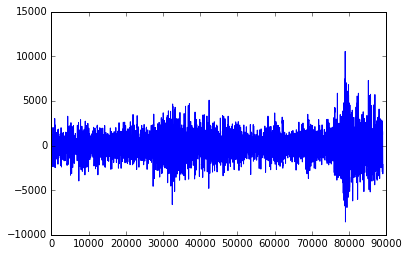

In [7]:
bufread = moni.read_frames(2000)
chunk = bufread.read_formatted()
plt.plot(chunk)
print rms(chunk)
print np.std(chunk)
print mad(chunk)

In [4]:
moni.monitor_status

'off'

In [ ]:
chunk64=((np.array(chunk, dtype=np.int64)))
np.sqrt(sum(np.transpose(chunk64)*chunk64)/chunk64.size)

In [ ]:
plt.plot(moni.stream_buffer.read_formatted())

In [ ]:
moni.stop_triggered_mode()

In [ ]:
moni.stop_triggered_mode()

In [ ]:
moni.record_epoch_max_elem

In [ ]:
def interrupt_wrapper(func):
        

In [ ]:
import glob
import os
glob.glob()